In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/grid-search/best_model_svd.pkl
/kaggle/input/edsa-movie-recommendation-predict/sample_submission.csv
/kaggle/input/edsa-movie-recommendation-predict/movies.csv
/kaggle/input/edsa-movie-recommendation-predict/imdb_data.csv
/kaggle/input/edsa-movie-recommendation-predict/genome_tags.csv
/kaggle/input/edsa-movie-recommendation-predict/genome_scores.csv
/kaggle/input/edsa-movie-recommendation-predict/train.csv
/kaggle/input/edsa-movie-recommendation-predict/test.csv
/kaggle/input/edsa-movie-recommendation-predict/tags.csv
/kaggle/input/edsa-movie-recommendation-predict/links.csv


In [1]:
!pip install comet_ml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.6/549.6 kB 9.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 60.4 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.1/510.1 kB 35.0 MB/s eta 0:00:00
  Attempting uninstall: websocket-client
    Found existing installation: websocket-client 1.6.0
    Uninstalling websocket-client-1.6.0:
      Successfully uninstalled websocket-client-1.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab-lsp 4.2.0 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.


In [51]:
from comet_ml import Experiment
from comet_ml.integration.pytorch import log_model

experiment = Experiment(
  api_key = "3uxi9A8PitoagJExAPVWwzIDY",
  project_name = "gridsearchCV_model",
  workspace="onyekaekesi"
)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/kaggle/working' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/onyekaekesi/gridsearchcv-model/320896ee2c4f43c1be3238e3600d08c6



In [5]:
import cufflinks as cf
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Entity featurization and similarity computation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Libraries used during sorting procedures.
import operator # <-- Convienient item retrieval during iteration 
import heapq # <-- Efficient sorting of large lists

sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (15,10)})

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [7]:
movies = pd.read_csv("/kaggle/input/edsa-movie-recommendation-predict/movies.csv")
movies.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [8]:
tags = pd.read_csv('/kaggle/input/edsa-movie-recommendation-predict/tags.csv')
tags.head(3)

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598


In [9]:
train = pd.read_csv('/kaggle/input/edsa-movie-recommendation-predict/train.csv')
train.head(3)

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539


In [10]:
test = pd.read_csv('/kaggle/input/edsa-movie-recommendation-predict/test.csv')
test.head(3)

,userId,movieId
0,1,2011
1,1,4144
2,1,5767


In [11]:
genome_score=pd.read_csv('/kaggle/input/edsa-movie-recommendation-predict/genome_scores.csv')
genome_score.head(3)

,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250


In [13]:
genome_tags=pd.read_csv('/kaggle/input/edsa-movie-recommendation-predict/genome_tags.csv')
genome_tags.head(3)

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century


In [14]:
imdb_data=pd.read_csv('/kaggle/input/edsa-movie-recommendation-predict/imdb_data.csv')
imdb_data.head(3)

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry


In [15]:
links=pd.read_csv('/kaggle/input/edsa-movie-recommendation-predict/links.csv')
links.head(3)

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0


In [16]:
print('genome_score:', genome_score.shape)
print('genome_tags:', genome_tags.shape)
print('imdb_data:', imdb_data.shape)
print('links:', links.shape)

genome_score: (15584448, 3)
genome_tags: (1128, 2)
imdb_data: (27278, 6)
links: (62423, 3)


In [17]:
print('movies:', movies.shape)
print('tags:', tags.shape)
print('train:', train.shape)
print('test:', test.shape)

movies: (62423, 3)
tags: (1093360, 4)
train: (10000038, 4)
test: (5000019, 2)


In [18]:
train.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [19]:
train.describe()

,userId,movieId,rating,timestamp
count,1.000004e+07,1.000004e+07,1.000004e+07,1.000004e+07
mean,8.119909e+04,2.138911e+04,3.533395e+00,1.215677e+09
std,4.679359e+04,3.919578e+04,1.061124e+00,2.268921e+08
min,1.000000e+00,1.000000e+00,5.000000e-01,7.896520e+08
25%,4.051000e+04,1.197000e+03,3.000000e+00,1.011742e+09
50%,8.091400e+04,2.947000e+03,3.500000e+00,1.199019e+09
75%,1.215790e+05,8.630000e+03,4.000000e+00,1.447242e+09
max,1.625410e+05,2.091710e+05,5.000000e+00,1.574328e+09


In [20]:
train.kurtosis()

userId      -1.197634
movieId      4.351014
rating       0.221102
timestamp   -1.316891
dtype: float64

In [21]:
train.skew()

userId       0.007477
movieId      2.200436
rating      -0.703118
timestamp   -0.017331
dtype: float64

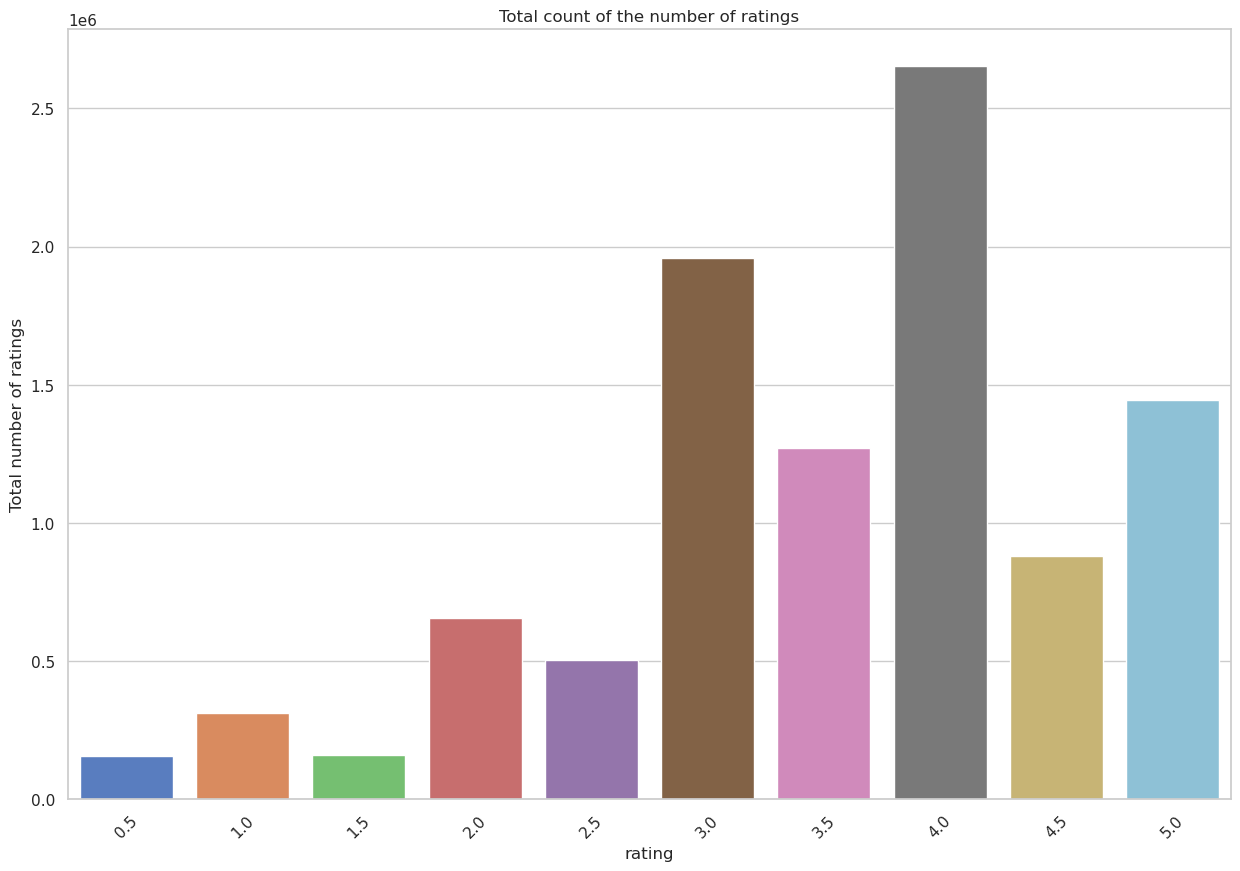

Average rating in dataset: 3.5333951730983424


In [22]:
# Create the count plot
sns.countplot(data=train, x='rating')

# Customize the plot
plt.xlabel('rating')
plt.ylabel('Total number of ratings')
plt.title('Total count of the number of ratings')
plt.xticks(rotation=45)

# Display the plot
plt.show()
print (f'Average rating in dataset: {np.mean(train["rating"])}')

## Pre-processing for performing content base filtering 

In [23]:
# Columns to be added from imdb_data to train 
columns_to_add = ['title_cast', 'director']

# Using pd.concat() to add columns
train_df = pd.concat([train, imdb_data[columns_to_add]], axis=1)

print(train_df.head(3))

   userId  movieId  rating   timestamp  \
0    5163    57669     4.0  1518349992   
1  106343        5     4.5  1206238739   
2  146790     5459     5.0  1076215539   

                                          title_cast             director  
0  Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...        John Lasseter  
1  Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...   Jonathan Hensleigh  
2  Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...  Mark Steven Johnson  


In [24]:
# Columns to be added from movies to train 
columns_to_add = ['title','genres']

# Using pd.concat() to add columns
train_df = pd.concat([train_df, movies[columns_to_add]], axis=1)

print(train_df.head(3))

   userId  movieId  rating   timestamp  \
0    5163    57669     4.0  1518349992   
1  106343        5     4.5  1206238739   
2  146790     5459     5.0  1076215539   

                                          title_cast             director  \
0  Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...        John Lasseter   
1  Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...   Jonathan Hensleigh   
2  Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...  Mark Steven Johnson   

                     title                                       genres  
0         Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy  
1           Jumanji (1995)                   Adventure|Children|Fantasy  
2  Grumpier Old Men (1995)                               Comedy|Romance  


In [25]:
#search for dublicates in the train_df 
# Removing duplicates based on a subset of columns
train_df = train_df.drop_duplicates(subset=['movieId'], keep='first')
print("DataFrame without duplicates:")
print(train_df.head(3))

DataFrame without duplicates:
   userId  movieId  rating   timestamp  \
0    5163    57669     4.0  1518349992   
1  106343        5     4.5  1206238739   
2  146790     5459     5.0  1076215539   

                                          title_cast             director  \
0  Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...        John Lasseter   
1  Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...   Jonathan Hensleigh   
2  Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...  Mark Steven Johnson   

                     title                                       genres  
0         Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy  
1           Jumanji (1995)                   Adventure|Children|Fantasy  
2  Grumpier Old Men (1995)                               Comedy|Romance  


In [26]:
train_df.isnull().sum()

userId            0
movieId           0
rating            0
timestamp         0
title_cast    44540
director      44515
title         39743
genres        39743
dtype: int64

In [65]:
#Drop empty rows
#train_df.dropna(subset=['title_cast','director','title','genres','auth_tags'], inplace=True)

In [66]:
#train_df.isnull().sum()

In [67]:
#train_df['auth_tags'] = (pd.Series(train_df[['director', 'genres']]
                      #.fillna('')
                      #.values.tolist()).str.join(' '))

# Convienient indexes to map between book titles and indexes of 
# the books dataframe
#titles = train_df['title']
#indices = pd.Series(train_df.index, index=train_df['title'])

In [68]:
#tf = TfidfVectorizer(analyzer='word', ngram_range=(1,2),
                     #min_df=0, stop_words='english')

# Produce a feature matrix, where each row corresponds to a movie,
# with TF-IDF features as columns 
#tf_authTags_matrix = tf.fit_transform(train_df['auth_tags'])

In [69]:
# WORKING BON THESE REFUSED TO RUN .... PROBABLY TOO LARGE 
#util_matrix = train.pivot_table(index=['userId'],
                                       #columns=['movieId'],
                                       #values='rating')
#util_matrix.shape

# STILL WORKING ON THESE LINES OF CODE
#Create a neat version of the utility matrix to assist with plotting book titles 
movies_ratings['movie_Id'] = train['movieId'].apply(lambda x: x[:20])
util_matrix_neat = train.pivot_table(index=['userid'],
                                            columns=['movieId'],
                                            values='rating')

fig, ax = plt.subplots(figsize=(15,5))
#We select only the first 100 users for ease of computation and visualisation. 
#You can play around with this value to see more of the utility matrix. 
_ = sns.heatmap(util_matrix_neat[:100], annot=False, ax=ax).set_title('GoodBooks Utility Matrix')


# STILL WORKING ON THESE TOO. 
#Compute the similarity matrix using the cosine similarity metric
user_similarity = cosine_similarity(util_matrix_sparse.T)
#Save the matrix as a dataframe to allow for easier indexing  
user_sim_df = pd.DataFrame(user_similarity,
                           index = util_matrix_norm.columns,
                           columns = util_matrix_norm.columns)

#Review a small portion of the constructed similartiy matrix  
user_sim_df[:5]

In [70]:
test.shape

(5000019, 2)

In [31]:
from surprise import Reader
from surprise import Dataset
from surprise import accuracy
from surprise import NMF
from surprise.model_selection import train_test_split

In [33]:
train_df = train.copy()
reader = Reader()
df = Dataset.load_from_df(train_df[['userId', 'movieId', 'rating']], reader)

In [34]:
trainingset, testingset = train_test_split(df, test_size=0.2, random_state=42)

In [35]:
nmf_model = NMF()
nmf_model.fit(trainingset)

In [36]:
prediction = nmf_model.test(testingset) 
test_data = pd.DataFrame(prediction)

In [50]:
rmse = accuracy.rmse(prediction)


RMSE: 0.8819


In [37]:
test_data.head(3)

,uid,iid,r_ui,est,details
0,120843,106782,4.0,4.847829,{'was_impossible': False}
1,64583,2,4.5,3.338726,{'was_impossible': False}
2,88952,38304,4.5,4.862994,{'was_impossible': False}


In [38]:
ratings=[nmf_model.predict(row.userId, row.movieId) for _,row in test.iterrows()]
ratings[:3]

[Prediction(uid=1, iid=2011, r_ui=None, est=3.919002435278876, details={'was_impossible': False}),
 Prediction(uid=1, iid=4144, r_ui=None, est=4.532800306398359, details={'was_impossible': False}),
 Prediction(uid=1, iid=5767, r_ui=None, est=3.3524972235441877, details={'was_impossible': False}),
 Prediction(uid=1, iid=6711, r_ui=None, est=3.846786605274726, details={'was_impossible': False}),
 Prediction(uid=1, iid=7318, r_ui=None, est=2.76022275837817, details={'was_impossible': False}),
 Prediction(uid=1, iid=8405, r_ui=None, est=3.9631723448460434, details={'was_impossible': False}),
 Prediction(uid=1, iid=8786, r_ui=None, est=3.6047319607104256, details={'was_impossible': False}),
 Prediction(uid=2, iid=150, r_ui=None, est=3.490643265629988, details={'was_impossible': False}),
 Prediction(uid=2, iid=356, r_ui=None, est=3.1938219357442046, details={'was_impossible': False}),
 Prediction(uid=2, iid=497, r_ui=None, est=3.93259283981141, details={'was_impossible': False}),
 Prediction

In [41]:
data_prediction=pd.DataFrame(ratings)
data_prediction.head(3)

,uid,iid,r_ui,est,details
0,1,2011,None,3.919002,{'was_impossible': False}
1,1,4144,None,4.532800,{'was_impossible': False}
2,1,5767,None,3.352497,{'was_impossible': False}


In [42]:
data_prediction=data_prediction.rename(columns={'uid':'userId', 'iid':'movieId','est':'rating'})
data_prediction.drop(['r_ui','details'],axis=1,inplace=True)
data_prediction.head()

,userId,movieId,rating
0,1,2011,3.919002
1,1,4144,4.532800
2,1,5767,3.352497
3,1,6711,3.846787
4,1,7318,2.760223


In [43]:
data_prediction['Id']=data_prediction.apply(lambda x:'%s_%s' % (x['userId'],x['movieId']),axis=1)
data_prediction['Id']=data_prediction.apply(lambda x:'%s_%s' % (x['userId'],x['movieId']),axis=1)
data_prediction.head()

,userId,movieId,rating,Id
0,1,2011,3.919002,1_2011
1,1,4144,4.532800,1_4144
2,1,5767,3.352497,1_5767
3,1,6711,3.846787,1_6711
4,1,7318,2.760223,1_7318


In [44]:
data_prediction.drop(['userId', 'movieId'], inplace=True, axis= 1)

In [45]:
data_prediction = data_prediction[['Id', 'rating']]
data_prediction.head()

,Id,rating
0,1_2011,3.919002
1,1_4144,4.532800
2,1_5767,3.352497
3,1_6711,3.846787
4,1_7318,2.760223


In [51]:
data_prediction.shape 

(5000019, 2)

In [67]:
experiment.log_metric("RMSE", rmse)

In [69]:
import pickle
model_path = "nmf.pkl"
with open(model_path, 'wb') as file:
    pickle.dump(nmf_model, file)

In [70]:
data_prediction.to_csv("nmf.csv", index=False)